In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_symbols(text):
    text = text.lower()
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def normalize_alay(text, alay_dict_map):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def tokenized(data):
    return data.apply(nltk.word_tokenize)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('indonesian'))
    return [word for word in tokens if word not in stop_words]

In [ ]:
# Load dataset
df = pd.read_csv('/content/datasetNH(balance).csv')

In [ ]:
# Load alay dictionary
alay_dict = pd.read_csv('new_kamusalay.csv', names=['original', 'replacement'], encoding='latin-1')
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

In [ ]:
X = df['text_data']
y = df['sentiment']

In [ ]:
# Lowercase dan remove special characters
X = X.apply(remove_symbols)
print("After removing symbols:")
print(X.head())

After removing symbols:
0        108 mahasiswa magang kampus merdeka di bpjph 
1    unearned revenue definisi contoh dan metode pe...
2    apple tunda peluncuran macbook air hingga nove...
3    saham bukalapak buka melejit 6 ihsg berbalik m...
4    10 wisata kota tua jakarta yang instagramable ...
Name: text_data, dtype: object


In [ ]:
# Normalize menggunakan alay dictionary
X = X.apply(lambda x: normalize_alay(x, alay_dict_map))
print("\nAfter normalizing alay words:")
print(X.head())


After normalizing alay words:
0        108 mahasiswa magang kampus merdeka di bpjph 
1    unearned revenue definisi contoh dan metode pe...
2    apple tunda peluncuran macbook air hingga nove...
3    saham bukalapak buka melejit 6 indeks harga sa...
4    10 wisata kota tua jakarta yang instagramable ...
Name: text_data, dtype: object


In [ ]:
# Tokenized
X = tokenized(X)
print("\nAfter tokenization:")
print(X.head())


After tokenization:
0    [108, mahasiswa, magang, kampus, merdeka, di, ...
1    [unearned, revenue, definisi, contoh, dan, met...
2    [apple, tunda, peluncuran, macbook, air, hingg...
3    [saham, bukalapak, buka, melejit, 6, indeks, h...
4    [10, wisata, kota, tua, jakarta, yang, instagr...
Name: text_data, dtype: object


In [ ]:
# Remove stopwords
X = X.apply(remove_stopwords)
print("\nAfter removing stopwords:")
print(X.head())


After removing stopwords:
0     [108, mahasiswa, magang, kampus, merdeka, bpjph]
1    [unearned, revenue, definisi, contoh, metode, ...
2    [apple, tunda, peluncuran, macbook, air, novem...
3    [saham, bukalapak, buka, melejit, 6, indeks, h...
4    [10, wisata, kota, tua, jakarta, instagramable...
Name: text_data, dtype: object


In [ ]:
# Konversi label sentiment menjadi angka menggunakan LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Split dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tokenisasi teks
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
# Ubah teks menjadi urutan angka
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding agar panjang urutan sama
max_len = max(len(seq) for seq in X_train_seq)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
from keras.callbacks import ModelCheckpoint
# Model LSTM
embedding_dim = 30
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=100))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Menyusun ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Melatih model dengan menggunakan callback ModelCheckpoint
history = model.fit(X_train_pad, y_train,
                    epochs=25,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[checkpoint])

Epoch 1/25
189/190 [============================>.] - ETA: 0s - loss: 0.5539 - accuracy: 0.6938
Epoch 1: val_accuracy improved from -inf to 0.81316, saving model to best_model.h5
190/190 [==============================] - 7s 26ms/step - loss: 0.5524 - accuracy: 0.6946 - val_loss: 0.4435 - val_accuracy: 0.8132
Epoch 2/25
  7/190 [>.............................] - ETA: 3s - loss: 0.1739 - accuracy: 0.9464

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/190 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.9016
Epoch 2: val_accuracy improved from 0.81316 to 0.84211, saving model to best_model.h5
190/190 [==============================] - 4s 21ms/step - loss: 0.2705 - accuracy: 0.9016 - val_loss: 0.3811 - val_accuracy: 0.8421
Epoch 3/25
189/190 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9540
Epoch 3: val_accuracy improved from 0.84211 to 0.85987, saving model to best_model.h5
190/190 [==============================] - 5s 28ms/step - loss: 0.1350 - accuracy: 0.9543 - val_loss: 0.4160 - val_accuracy: 0.8599
Epoch 4/25
189/190 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9714
Epoch 4: val_accuracy improved from 0.85987 to 0.86776, saving model to best_model.h5
190/190 [==============================] - 4s 21ms/step - loss: 0.0873 - accuracy: 0.9712 - val_loss: 0.4792 - val_accuracy: 0.8678
Epoch 5/25
190/190 [==============================] - ETA: 0s - loss:

In [ ]:
# Evaluasi model
print("\nEvaluating model...")
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Evaluating model...
48/48 [==============================] - 0s 9ms/step - loss: 0.7144 - accuracy: 0.8658
Loss: 0.714404284954071, Accuracy: 0.8657894730567932


48/48 [==============================] - 1s 7ms/step


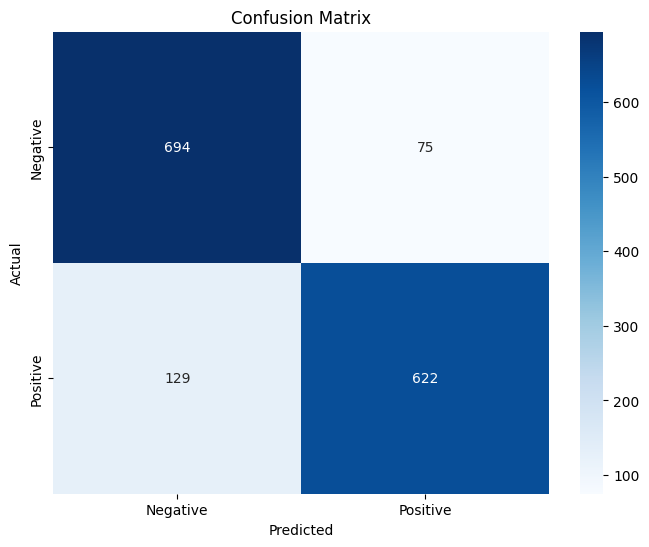

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       769
           1       0.89      0.83      0.86       751

    accuracy                           0.87      1520
   macro avg       0.87      0.87      0.87      1520
weighted avg       0.87      0.87      0.87      1520



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

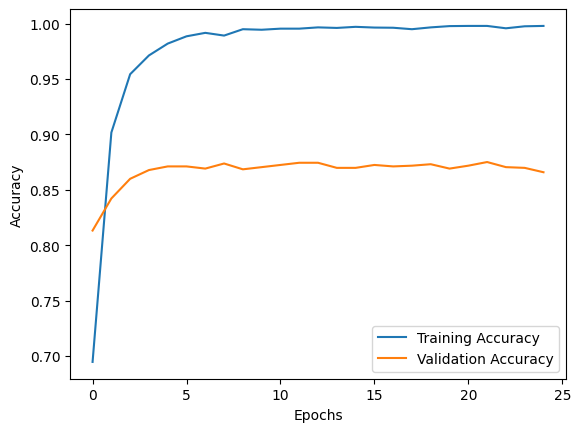

In [ ]:
# Plot akurasi training dan validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
text_to_test = "Jokowi Akui Nyaman dengan Partai Golkar"

text_to_test = remove_symbols(text_to_test)
text_to_test = normalize_alay(text_to_test, alay_dict_map)
tokenized_text = tokenized(pd.Series([text_to_test]))
filtered_text = remove_stopwords(tokenized_text.iloc[0])

text_seq = tokenizer.texts_to_sequences([filtered_text])

text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post', truncating='post')

predicted_label = model.predict(text_pad)

predicted_sentiment = "Positive" if predicted_label > 0.5 else "Negative"
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Confidence Level: {predicted_label}")

1/1 [==============================] - 0s 24ms/step
Predicted Sentiment: Negative
Confidence Level: [[0.00042017]]


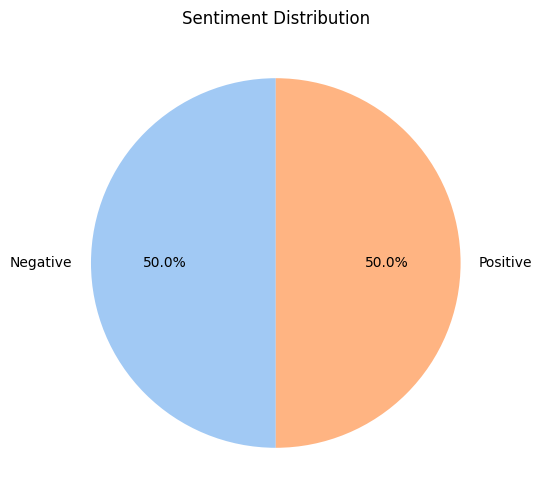

In [ ]:
# Piechart sentiment count keseluruhan
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Sentiment Distribution')
plt.show()

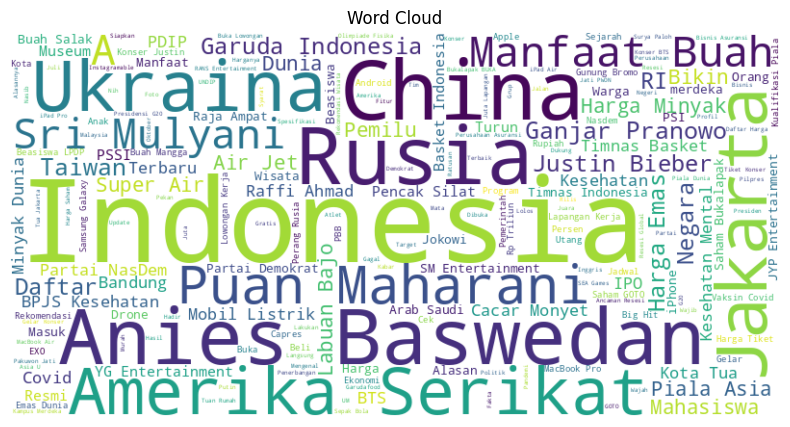

In [ ]:
# Word Cloud
all_words = ' '.join(df['text_data'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords.words('indonesian')).generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [ ]:
model.save('NHmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
